# *Summary*

## This notebook extends the credit risk modeling from the credit log modeling project.

In this notebook, a credit risk model using gradient boosted trees is developed to predict loan defaults with probability. This model can be used to automate the approval and denial of loan applications more accurately.

The model achieved a recall of 73% and an accuracy of 93.3% in predicting loan defaults on a dataset of 32,576 loans and 12 benchmarks, using a probability threshold of 60%. With this model, the default rate would decrease from 22% to 7%, minimizing risk for both the lender and the applicant.

The top five most important features for determining a loan default are the applicant's income, age, and employment length, as well as the loan's interest rate and amount.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import model_selection,linear_model, metrics
import xgboost as xgb
from sklearn.metrics import classification_report

In [2]:
cr_data = pd.read_csv("credit_risk_dataset.csv")

emp_len_null = cr_data[cr_data['person_emp_length'].isnull()].index
int_rate_null = cr_data[cr_data['loan_int_rate'].isnull()].index

cr_data['person_emp_length'].fillna((cr_data['person_emp_length'].median()), inplace=True)
cr_data['loan_int_rate'].fillna((cr_data['loan_int_rate'].median()), inplace = True)

cr_data = cr_data.rename(columns = {"cb_person_default_on_file":"default_hist", "cb_person_cred_hist_length": "cr_hist_len"})

cr_clean1 = cr_data[cr_data['person_age']<=100]

# one hot encoding categorical variables
num_col = cr_clean1.select_dtypes(exclude = 'object')
char_col = cr_clean1.select_dtypes(include = 'object')

encoded_char_col = pd.get_dummies(char_col)

cr_clean2 = pd.concat([num_col, encoded_char_col], axis=1)
cr_clean2

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cr_hist_len,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,default_hist_N,default_hist_Y
0,22,59000,123.0,35000,16.02,1,0.59,3,False,False,...,False,False,False,False,True,False,False,False,False,True
1,21,9600,5.0,1000,11.14,0,0.10,2,False,False,...,False,False,True,False,False,False,False,False,True,False
2,25,9600,1.0,5500,12.87,1,0.57,3,True,False,...,False,False,False,True,False,False,False,False,True,False
3,23,65500,4.0,35000,15.23,1,0.53,2,False,False,...,False,False,False,True,False,False,False,False,True,False
4,24,54400,8.0,35000,14.27,1,0.55,4,False,False,...,False,False,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,1.0,5800,13.16,0,0.11,30,True,False,...,False,False,False,True,False,False,False,False,True,False
32577,54,120000,4.0,17625,7.49,0,0.15,19,True,False,...,False,True,False,False,False,False,False,False,True,False
32578,65,76000,3.0,35000,10.99,1,0.46,28,False,False,...,False,False,True,False,False,False,False,False,True,False
32579,56,150000,5.0,15000,11.48,0,0.10,26,True,False,...,False,False,True,False,False,False,False,False,True,False


In [3]:
# Split Train and Test Sets
Y = cr_clean2['loan_status']
X = cr_clean2.drop('loan_status',axis=1)
 


x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y, random_state=2020, test_size=.30)

#Start of gradient boosted tree

xgb_model = xgb.XGBClassifier() # initialize tree

xgb_model.fit(x_train, np.ravel(y_train)) # train tree

predict_xgb = xgb_model.predict_proba(x_test) # 1st col = pred val, 2nd col = pred prob

predict_xgb_prob = pd.DataFrame(predict_xgb[:,1],columns = ['Default Probability'])

pd.concat([predict_xgb_prob, y_test.reset_index(drop=True)],axis=1)


,Default Probability,loan_status
0,0.033276,0
1,0.000701,0
2,0.011722,0
3,0.002813,0
4,0.107398,0
...,...,...
9768,0.045192,0
9769,0.015024,0
9770,0.999846,1
9771,0.044685,0


In [4]:
X

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cr_hist_len,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,default_hist_N,default_hist_Y
0,22,59000,123.0,35000,16.02,0.59,3,False,False,False,...,False,False,False,False,True,False,False,False,False,True
1,21,9600,5.0,1000,11.14,0.10,2,False,False,True,...,False,False,True,False,False,False,False,False,True,False
2,25,9600,1.0,5500,12.87,0.57,3,True,False,False,...,False,False,False,True,False,False,False,False,True,False
3,23,65500,4.0,35000,15.23,0.53,2,False,False,False,...,False,False,False,True,False,False,False,False,True,False
4,24,54400,8.0,35000,14.27,0.55,4,False,False,False,...,False,False,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,1.0,5800,13.16,0.11,30,True,False,False,...,False,False,False,True,False,False,False,False,True,False
32577,54,120000,4.0,17625,7.49,0.15,19,True,False,False,...,False,True,False,False,False,False,False,False,True,False
32578,65,76000,3.0,35000,10.99,0.46,28,False,False,False,...,False,False,True,False,False,False,False,False,True,False
32579,56,150000,5.0,15000,11.48,0.10,26,True,False,False,...,False,False,True,False,False,False,False,False,True,False


In [5]:
print("There are {} features in cr_clean2".format(cr_clean2.shape[1]))
round(xgb_model.score(x_test,y_test),3)

There are 27 features in cr_clean2


0.932

## Evaluation Metrics

In [6]:
y_predict_xgb = xgb_model.predict(x_test)

print(classification_report(y_test, y_predict_xgb))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      7684
           1       0.94      0.73      0.82      2089

    accuracy                           0.93      9773
   macro avg       0.94      0.86      0.89      9773
weighted avg       0.93      0.93      0.93      9773



In [7]:
# display feature and their importance
feat_imp = xgb_model.get_booster().get_score(importance_type='weight')

feat_imp

{'person_age': 343.0,
 'person_income': 724.0,
 'person_emp_length': 339.0,
 'loan_amnt': 334.0,
 'loan_int_rate': 501.0,
 'loan_percent_income': 313.0,
 'cr_hist_len': 205.0,
 'person_home_ownership_MORTGAGE': 48.0,
 'person_home_ownership_OTHER': 4.0,
 'person_home_ownership_OWN': 44.0,
 'person_home_ownership_RENT': 65.0,
 'loan_intent_DEBTCONSOLIDATION': 72.0,
 'loan_intent_EDUCATION': 56.0,
 'loan_intent_HOMEIMPROVEMENT': 47.0,
 'loan_intent_MEDICAL': 71.0,
 'loan_intent_PERSONAL': 41.0,
 'loan_intent_VENTURE': 34.0,
 'loan_grade_A': 24.0,
 'loan_grade_B': 35.0,
 'loan_grade_C': 47.0,
 'loan_grade_D': 54.0,
 'loan_grade_E': 34.0,
 'loan_grade_F': 18.0,
 'loan_grade_G': 16.0,
 'default_hist_N': 28.0}

In [8]:
# columns not used
set(x_train.columns) - set(feat_imp)

{'default_hist_Y'}

The only feture not used was whether an applicant had a history of default.

In [9]:
# display top 5 most import features
sorted(feat_imp.items(), key=lambda kv: kv[1],reverse=True)[0:5]

[('person_income', 724.0),
 ('loan_int_rate', 501.0),
 ('person_age', 343.0),
 ('person_emp_length', 339.0),
 ('loan_amnt', 334.0)]

The top 5 most important features of determining a loan default depends on the applicant's income, age, and employment length and the loan's interest rate and amount.

In [10]:
import operator as op
sorted_feat_imp = dict(sorted(feat_imp.items(), key=op.itemgetter(1),reverse=True))
sorted_feat_imp

{'person_income': 724.0,
 'loan_int_rate': 501.0,
 'person_age': 343.0,
 'person_emp_length': 339.0,
 'loan_amnt': 334.0,
 'loan_percent_income': 313.0,
 'cr_hist_len': 205.0,
 'loan_intent_DEBTCONSOLIDATION': 72.0,
 'loan_intent_MEDICAL': 71.0,
 'person_home_ownership_RENT': 65.0,
 'loan_intent_EDUCATION': 56.0,
 'loan_grade_D': 54.0,
 'person_home_ownership_MORTGAGE': 48.0,
 'loan_intent_HOMEIMPROVEMENT': 47.0,
 'loan_grade_C': 47.0,
 'person_home_ownership_OWN': 44.0,
 'loan_intent_PERSONAL': 41.0,
 'loan_grade_B': 35.0,
 'loan_intent_VENTURE': 34.0,
 'loan_grade_E': 34.0,
 'default_hist_N': 28.0,
 'loan_grade_A': 24.0,
 'loan_grade_F': 18.0,
 'loan_grade_G': 16.0,
 'person_home_ownership_OTHER': 4.0}

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

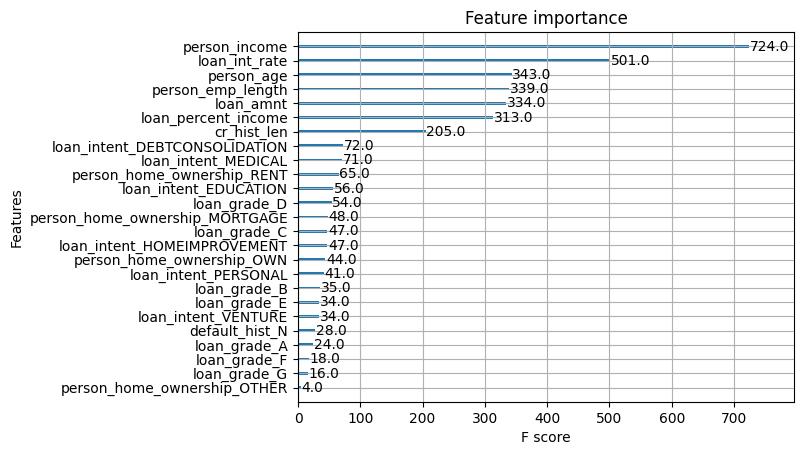

In [11]:
xgb.plot_importance(xgb_model,importance_type='weight')

In [12]:

remove_feats = []

for key in feat_imp.keys():
    if feat_imp[key] < 40:    # tried 
        remove_feats.append(key)
        
imp_data = X
for key in remove_feats:
    imp_data = imp_data.drop(key,axis=1)

In [13]:
imp_data.shape

(32576, 18)

The data has been reduced to 15 important features

In [14]:
display_most_imp_feat ={}
for key in list(imp_data.columns):
    if key  in feat_imp.keys():
        display_most_imp_feat[key] = feat_imp[key]

sorted(display_most_imp_feat.items(), key=lambda kv: kv[1],reverse=True)

[('person_income', 724.0),
 ('loan_int_rate', 501.0),
 ('person_age', 343.0),
 ('person_emp_length', 339.0),
 ('loan_amnt', 334.0),
 ('loan_percent_income', 313.0),
 ('cr_hist_len', 205.0),
 ('loan_intent_DEBTCONSOLIDATION', 72.0),
 ('loan_intent_MEDICAL', 71.0),
 ('person_home_ownership_RENT', 65.0),
 ('loan_intent_EDUCATION', 56.0),
 ('loan_grade_D', 54.0),
 ('person_home_ownership_MORTGAGE', 48.0),
 ('loan_intent_HOMEIMPROVEMENT', 47.0),
 ('loan_grade_C', 47.0),
 ('person_home_ownership_OWN', 44.0),
 ('loan_intent_PERSONAL', 41.0)]

In [15]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(imp_data, Y, random_state=2020, test_size=.30)

#Start of gradient boosted tree

xgb_model = xgb.XGBClassifier() # initialize tree

xgb_model.fit(x_train, np.ravel(y_train)) # train tree

predict_xgb = xgb_model.predict_proba(x_test) # 1st col = pred val, 2nd col = pred prob

predict_xgb_prob = pd.DataFrame(predict_xgb[:,1],columns = ['Default Probability'])

pd.concat([predict_xgb_prob, y_test.reset_index(drop=True)],axis=1)


,Default Probability,loan_status
0,0.025822,0
1,0.004510,0
2,0.016478,0
3,0.003207,0
4,0.080222,0
...,...,...
9768,0.051000,0
9769,0.010477,0
9770,0.999100,1
9771,0.033807,0


In [16]:
from sklearn.metrics import classification_report

In [17]:
y_preds =  xgb_model.predict(x_test)


print(classification_report(y_test, y_preds))


              precision    recall  f1-score   support

           0       0.93      0.99      0.96      7684
           1       0.95      0.73      0.82      2089

    accuracy                           0.93      9773
   macro avg       0.94      0.86      0.89      9773
weighted avg       0.93      0.93      0.93      9773



In [18]:
round(xgb_model.score(x_test,y_test),3)

0.932

In [19]:
thresh = np.linspace(0,1,21)
thresh

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [20]:
def find_opt_thresh(predict,thr =thresh, y_true = y_test):
    data = predict
    
    def_recalls = []
    nondef_recalls = []
    accs =[]

    
    for threshold in thr:
        # predicted values for each threshold
        data['loan_status'] = data['Default Probability'].apply(lambda x: 1 if x > threshold else 0 )
        
        accs.append(metrics.accuracy_score(y_true, data['loan_status']))
        
        stats = metrics.precision_recall_fscore_support(y_true, data['loan_status'])
        
        def_recalls.append(stats[1][1])
        nondef_recalls.append(stats[1][0])
        
        
    return accs, def_recalls, nondef_recalls

accs, def_recalls, nondef_recalls= find_opt_thresh(predict_xgb_prob)


/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


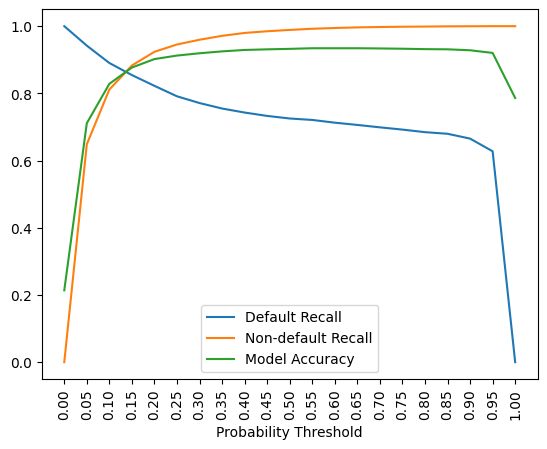

In [21]:
plt.plot(thresh,def_recalls)
plt.plot(thresh,nondef_recalls)
plt.plot(thresh,accs)
plt.xlabel("Probability Threshold")
plt.xticks(thresh, rotation = 'vertical')
plt.legend(["Default Recall","Non-default Recall","Model Accuracy"])
#plt.axvline(x=0.45, color='pink')
plt.show()

In [22]:
optim_threshold = accs.index(max(accs))

print(round(accs[optim_threshold],3))

thresh[optim_threshold]

0.934


0.55

In [23]:
cr_clean2.shape[1] - imp_data.shape[1]
# num of total features (including dummies) subtract important features with F score >= 40

9

In [24]:
# original loan defaults by previous default history
default_hist_status_tab= pd.crosstab(cr_clean1['default_hist'], cr_clean1['loan_status'])
default_hist_status_tab

loan_status,0,1
default_hist,,
N,21895,4936
Y,3573,2172


In [26]:
cr_clean1

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,default_hist,cr_hist_len
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


In [25]:
round(default_hist_status_tab.iloc[:,1].sum() /cr_data.shape[0],3)

0.218

In [28]:
# We will estimate our results to 2 dec places
round(0.218,2)

0.22

**The accuracy of the model was 93.3% and the recall was 0.73 with 15 important features and 12 feature removed once the data had been cleaned and encoded.**

**The gradient boosted tree performed 7.3% better than the logistics regression and had a higher probability threshold for default by 15%.**

**The initial loan default rate was 22%. With the `xgb_model`, the loan default rate should decrease to 6.7%. With this 15.1% improvement in default rate the lenders and applicants are even more so protected from risk.**